In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np
from acquire import remove_stopwords, basic_clean, tokenize , prep_and_split_data
from prepare_jag import prep_train, basic_clean3
import re
import os
from re import search
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras

from nltk.corpus import stopwords
import nltk

import random
random.seed(333)

In [2]:
train_df, val_df, test_df = prep_and_split_data()

Number of rows in training set: 37931
Number of rows in validation set: 2108
Number of rows in test set: 2107


/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
train_df

,case,student_notes,clean,targets
40751,9,"Stephanie Madden, a 20-year-old female, has co...",stephanie madden 20 year old female come docto...,[no relief with motrin or no relief with tylen...
37802,9,HPI: 20 yo f c/o headachesince yesterday which...,hpi 20 yo f c headachesince yesterday started ...,[no relief with motrin or no relief with tylen...
7459,3,Mr. Hamilton is a 35 year old male with 10 pac...,mr hamilton 35 year old male 10 pack year hist...,[fhx of pud or family history of peptic ulcer ...
33437,8,CC: difficult sleeping\r\nHPI: Pt is a 67F wit...,cc difficult sleeping hpi pt 67f 3weeks diffic...,"[increased appetite, son died 3 weeks ago, fem..."
39488,9,Ms. Madden is a 20 y/o female who presents wit...,ms madden 20 female presents severe headache o...,[no relief with motrin or no relief with tylen...
...,...,...,...,...
26853,5,Edie Whelan is 26 yo female with 5 year histor...,edie whelan 26 yo female 5 year history heart ...,"[onset 5 years ago, female, no caffeine use, a..."
16376,4,Patient is a 34 year old patient with a two we...,patient 34 year old patient two week history n...,"[lack of other thyroid symptoms, anxious or ne..."
22225,5,Edie Whelan is a 26 y/o F with a history of pa...,edie whelan 26 f history palpitations presents...,"[onset 5 years ago, female, no caffeine use, a..."
24524,5,HPI : 26 YO F C/O PALPITATION THAT STARTS SUDD...,hpi 26 yo f c palpitation starts suddenly sinc...,"[onset 5 years ago, female, no caffeine use, a..."


## Multi-label binarization
Let's preprocess our labels using the [StringLookup](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup) layer.

In [4]:
features = tf.ragged.constant(train_df['targets'].values)
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
lookup.adapt(features)
vocab = lookup.get_vocabulary()

2022-03-06 10:19:49.904801: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def invert_multi_hot(encoded_labels):
    '''Reverse a single multi-hot encoded label to a tuple of vocab terms.'''
    hot_indices = np.argwhere(encoded_labels == 1.0)[...,0]
    return np.take(vocab, hot_indices)

print('Vocabulary:\n')
print(vocab)

Vocabulary:

['[UNK]', 'female', 'nausea', '35 year', 'male', 'post prandial bloating or fullness with meals', 'nsaid use or nonsteroidal anti inflammatory drug use', 'no blood in stool', 'minimal to no change with tums', 'intermittent', 'getting worse or progressive or symptoms now daily', 'fhx of pud or family history of peptic ulcer disease', 'epigastric discomfort', 'duration 2 months', 'darker bowel movements', 'burning or gnawing or burning and gnawing', 'awakens at night', '2 to 3 beers a week', 'recent visit to emergency department with negative workup', 'onset 5 years ago', 'no illicit drug use', 'no chest pain', 'no caffeine use', 'increased stress', 'increased frequency recently', 'feels hot or feels clammy', 'fatigue or difficulty concentrating', 'episodes of heart racing', 'episodes last 15 to 30 minutes', 'episode of hand numbness or episode of finger numbness', 'associated throat tightness', 'associated sob or associated shortness of breath', 'associated nausea', 'associ

### Separate the individual targets from the label pool and then use it to represent a given label set with 0's and 1's

In [6]:
sample_label = train_df['targets'].iloc[0]
print(f'Original label: {sample_label}')

label_binarized = lookup([sample_label])
print(f'Label-binarized representation: {label_binarized}')

Original label: ['no relief with motrin or no relief with tylenol', '20 year', '1 day duration or 2 days duration', 'myalgias', 'global headache or diffuse headache', 'neck pain', 'vomiting', 'no rash', 'nausea', 'viral symptoms or rhinorrhea or scratchy throat', 'shares an apartment', 'meningococcal vaccine status unknown', 'family history of migraines', 'female', 'photophobia', 'no known illness contacts', 'subjective fever']
Label-binarized representation: [[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Data preprocessing and [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects

In [7]:
train_df['clean'].apply(lambda x: len(x.split(" "))).describe()

count    37931.000000
mean        97.733332
std         16.316496
min          7.000000
25%         88.000000
50%        100.000000
75%        109.000000
max        150.000000
Name: clean, dtype: float64

In [8]:
max_seqlen = 98
batch_size = 128
padding_token = '<pad>'
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe['targets'].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe['clean'].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

## Prepare the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects.

In [9]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Preview the dataset

In [10]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f'Student note: {text}')
    print(f'Targets: {invert_multi_hot(label[0])}')
    print(' ')

Student note: b'45 yo f complaint feelings nervousness constant worsening past weeks 3 weeks ago started giving lectures thinking giving lectures makes anxiety worse negatively impacting life causing decreased appetite mostly sunday nights monday morning prior lectures caused decreased libido ros heart racing pounding palpitations lightheadedness dizziness chest pain sob abd pain diarrhea constipations fever chills change hair cold heat intolerance agoraphobia pmh none lmp 1 week ago occurs regularly every 4 weeks heavy fhx father died heart attack age 65 shx lives 2 kids husband mother feels safe home denies tobacco illicit drug use drinks 1 2 alcoholic beverages month'
Targets: ['female' 'weight stable' 'stress due to caring for elderly parents'
 'no depressed mood' 'lack of other thyroid symptoms' 'insomnia'
 'heavy caffeine use' 'decreased appetite' 'anxious or nervous' '45 year']
 
Student note: b'hpi 67 yo f presents c inability sleep x 3wks pt reports difficulty falling asleep s

## Vectorization
Vectorize the text to represent it as a quantitative value. We will use [TextVectorization layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization)

In [11]:
# Get unique words in student notes.
vocabulary = set()
train_df['clean'].str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

42110


## Now we create our vectorization layer and map() to the [tf.data.Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) created earlier.

In [12]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode='tf_idf'
)

with tf.device('/CPU:0'):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

In [13]:
text_batch, label_batch = next(iter(train_dataset))

In [14]:
len(text_batch[0]), len(label_batch[0])

(42110, 132)

## Create a text classification model

In [15]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="softmax"),
        ]
    )
    return shallow_mlp_model

## Train our model

Epoch 1/2
297/297 [==============================] - 29s 96ms/step - loss: 0.0202 - categorical_accuracy: 0.2570 - val_loss: 1.1700e-04 - val_categorical_accuracy: 0.1546
Epoch 2/2
297/297 [==============================] - 29s 98ms/step - loss: 2.3018e-05 - categorical_accuracy: 0.2510 - val_loss: 1.0444e-04 - val_categorical_accuracy: 0.2116


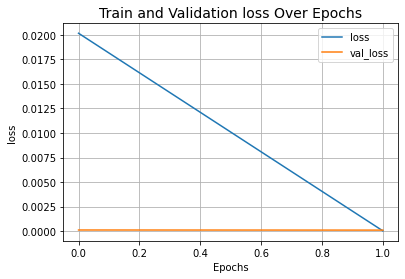

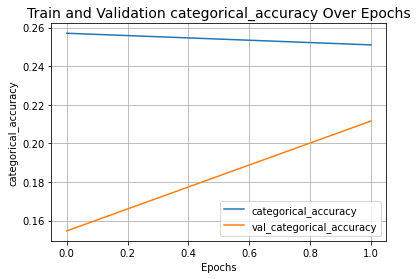

In [16]:
epochs = 2

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

## Evaluate the model

In [17]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 42110), dtype=tf.float32, name=None), TensorSpec(shape=(None, 132), dtype=tf.float32, name=None))>

In [18]:
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 42110), dtype=tf.float32, name=None), TensorSpec(shape=(None, 132), dtype=tf.float32, name=None))>

In [19]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 42110), dtype=tf.float32, name=None), TensorSpec(shape=(None, 132), dtype=tf.float32, name=None))>

In [20]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

17/17 [==============================] - 1s 27ms/step - loss: 7.8455e-05 - categorical_accuracy: 0.2140
Categorical accuracy on the test set: 21.4%.


In [22]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:10]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Student notes: {text}")
    print(f"Targets(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    all_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
            
        )
    ][:len(invert_multi_hot(label[0]))]
    print(f"Predicted Targets(s): ({', '.join([label for label in all_labels])})")
    print(" ")

Student notes: b'ms moore 45 female presenting generalized feelings nervousness last 3 4 weeks lots stress past couple months regarding work family 2 weeks ago workload increased feels anxious night giving lecture also reports decrease appetite however change weight also reports difficulty falling asleep last couple weeks thinking things falls asleep stays asleep gets 7 hours drinks 5 6 cups coffee day done years nothing makes nervousness better worse denies palpitations chest pain constipation fatigue meds otc tylenol needed allergies nkda pmhx none family hx dad sudden heart attack 61 social history occupation english professor etoh 1 2 drinks month tobacco never drugs never'
Targets(s): ['female' 'weight stable' 'stress due to caring for elderly parents'
 'no depressed mood' 'lack of other thyroid symptoms' 'insomnia'
 'heavy caffeine use' 'decreased appetite' 'anxious or nervous' '45 year']
Predicted Targets(s): (insomnia, stress due to caring for elderly parents, heavy caffeine us